<a href="https://colab.research.google.com/github/PLONTZNathan/MachineLearning_Assignment1/blob/elena/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/X_train.csv'
train = pd.read_csv(file_path)
file_path_2 = '/content/drive/MyDrive/X_test.csv'
test = pd.read_csv(file_path_2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [9]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

In [10]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [11]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

In [16]:
def get_time_vector(df, traj_len=257, tol=1e-8):

    num_traj = len(df) // traj_len
    feats = df.iloc[:, 1:-1].to_numpy()   # tutte le feature tranne tempo e Id

    for i in range(num_traj):
        start = i * traj_len
        end = start + traj_len

        block_feats = feats[start:end]
        zero_mask = np.all(np.abs(block_feats) < tol, axis=1)

        if not zero_mask.any():  # nessuna collisione
            return df.iloc[start:end, 0].to_numpy()  # solo la colonna tempo

    return None  # se tutte collidono

In [17]:
time_vec= get_time_vector(train, traj_len=257)
print(time_vec)

[ 0.         0.0390625  0.078125   0.117188   0.15625    0.195312
  0.234375   0.273438   0.3125     0.351562   0.390625   0.429688
  0.46875    0.507812   0.546875   0.585938   0.625      0.664062
  0.703125   0.742188   0.78125    0.820312   0.859375   0.898438
  0.9375     0.976562   1.01562    1.05469    1.09375    1.13281
  1.17188    1.21094    1.25       1.28906    1.32812    1.36719
  1.40625    1.44531    1.48438    1.52344    1.5625     1.60156
  1.64062    1.67969    1.71875    1.75781    1.79688    1.83594
  1.875      1.91406    1.95312    1.99219    2.03125    2.07031
  2.10938    2.14844    2.1875     2.22656    2.26562    2.30469
  2.34375    2.38281    2.42188    2.46094    2.5        2.53906
  2.57812    2.61719    2.65625    2.69531    2.73438    2.77344
  2.8125     2.85156    2.89062    2.92969    2.96875    3.00781
  3.04688    3.08594    3.125      3.16406    3.20312    3.24219
  3.28125    3.32031    3.35938    3.39844    3.4375     3.47656
  3.51562    3.55469 

In [18]:
def keep_first_zero_time(df, time_vec, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end].copy()

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero_rel = int(np.argmax(zero_mask))   # posizione relativa
            # change the t=0 to t=time_vec[i]
            traj.iat[first_zero_rel, 0] = time_vec[first_zero_rel]
            traj = traj.iloc[:first_zero_rel + 1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [19]:
train_first_row_time=keep_first_zero_time(train, time_vec, traj_len=257, tol=1e-8)

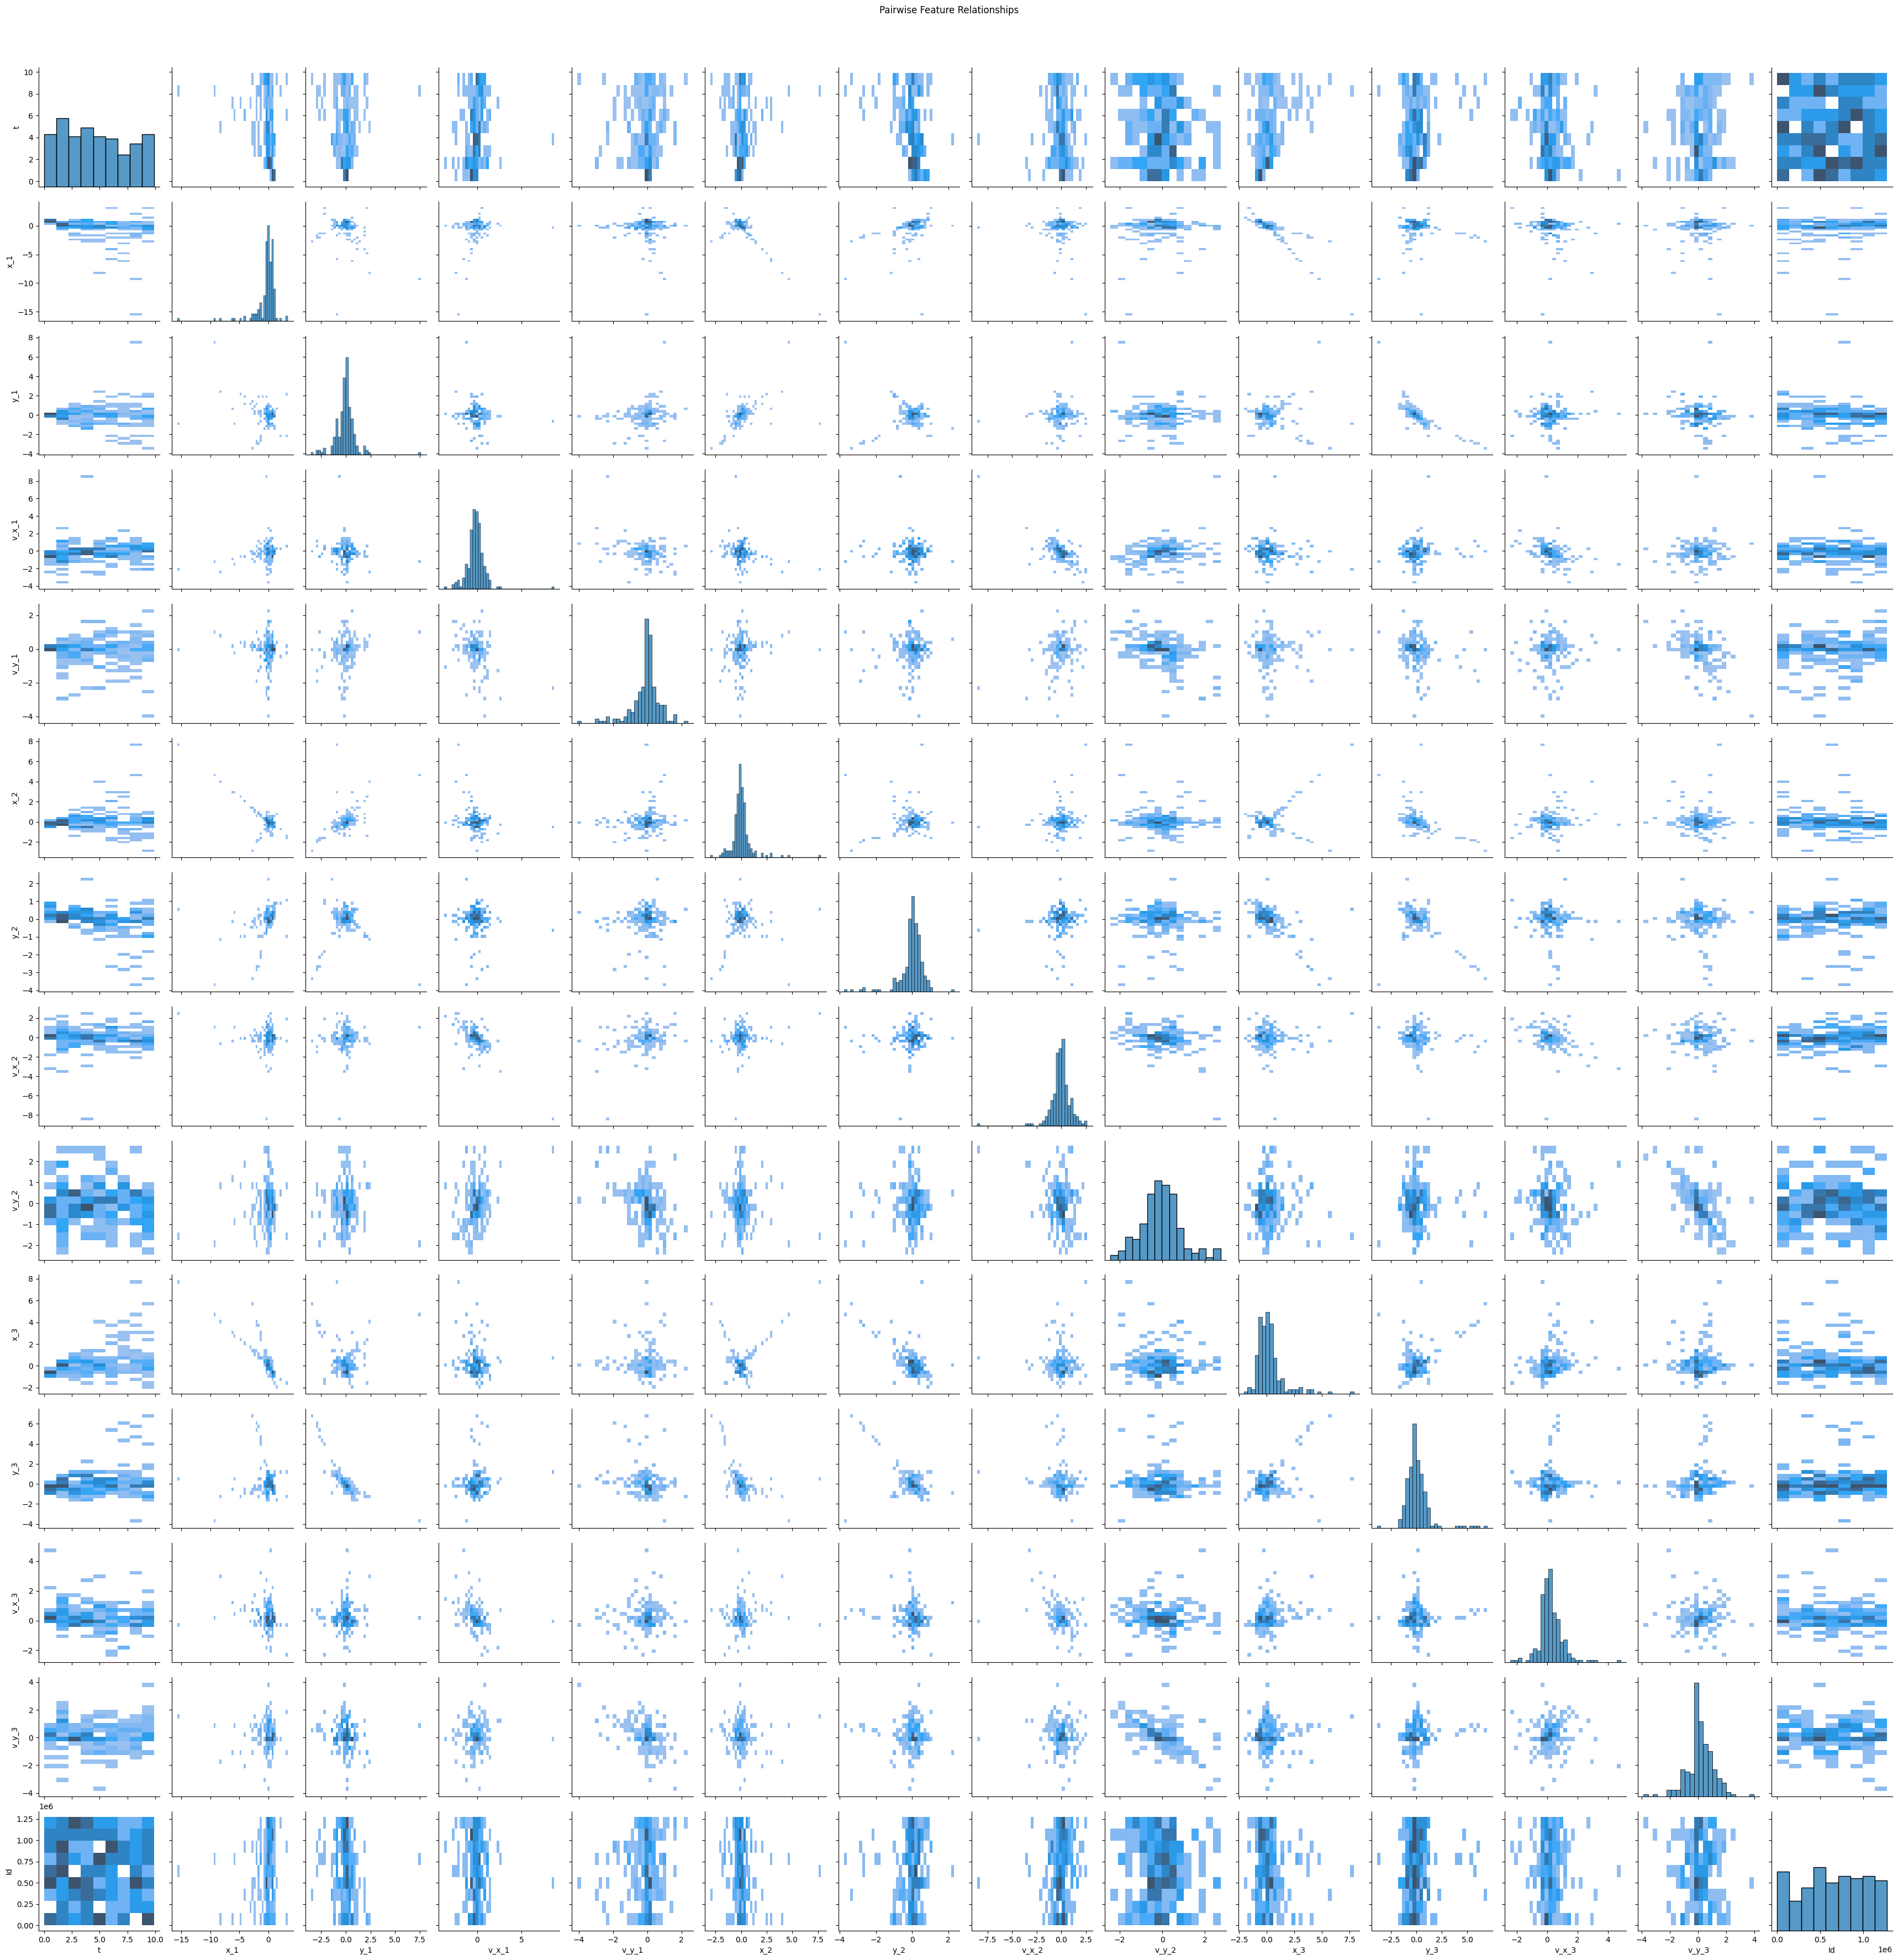

In [20]:
# Explore pairwise relationships
import seaborn as sns
sns.pairplot(train_first_row_time.sample(200, random_state=42), kind="hist")
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

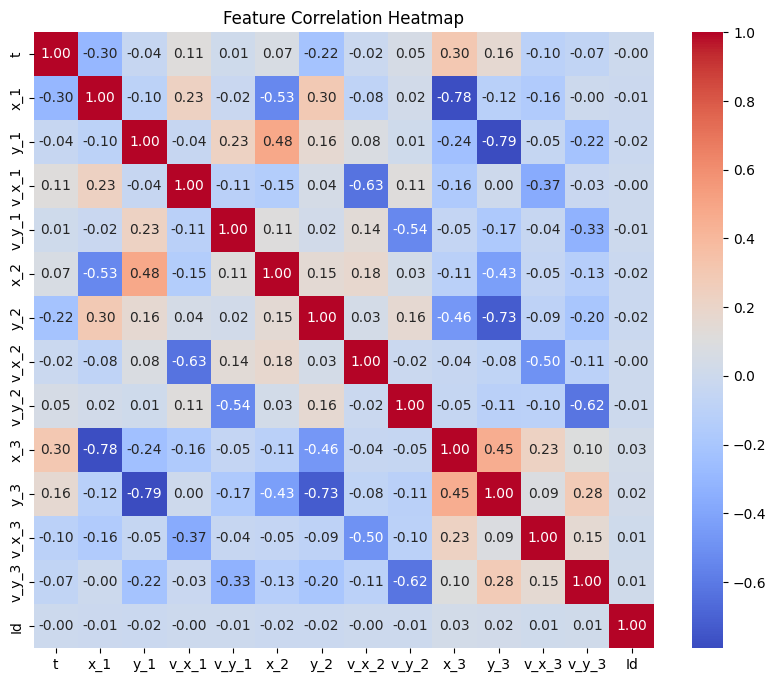

Highly correlated feature pairs:

   Feature_1 Feature_2  Correlation  abs_corr
32       y_1       y_3    -0.792861  0.792861
20       x_1       x_3    -0.781003  0.781003
66       y_2       y_3    -0.728558  0.728558
39     v_x_1     v_x_2    -0.625514  0.625514
79     v_y_2     v_y_3    -0.622942  0.622942
49     v_y_1     v_y_2    -0.536507  0.536507
16       x_1       x_2    -0.534273  0.534273
73     v_x_2     v_x_3    -0.495851  0.495851
27       y_1       x_2     0.484453  0.484453
65       y_2       x_3    -0.464371  0.464371


In [21]:
#Compute the correlation matrix
corr = train_first_row_time.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify pairs with high correlation
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation"})
)

# Sort by absolute correlation descending
corr_pairs["abs_corr"] = corr_pairs["Correlation"].abs()
corr_pairs = corr_pairs.sort_values("abs_corr", ascending=False)

print("Highly correlated feature pairs:\n")
print(corr_pairs.head(10))

Since all correlations are below 0.8, we decide to keep them; however, based on our prior physical knowledge (v = dx/dt), we know that velocity is derived from position and time, so we retain position and time and remove velocity features.

Removed velocity features: ['v_x_1', 'v_x_2', 'v_x_3', 'v_y_1', 'v_y_2', 'v_y_3']
Reduced shape: (1090737, 8)


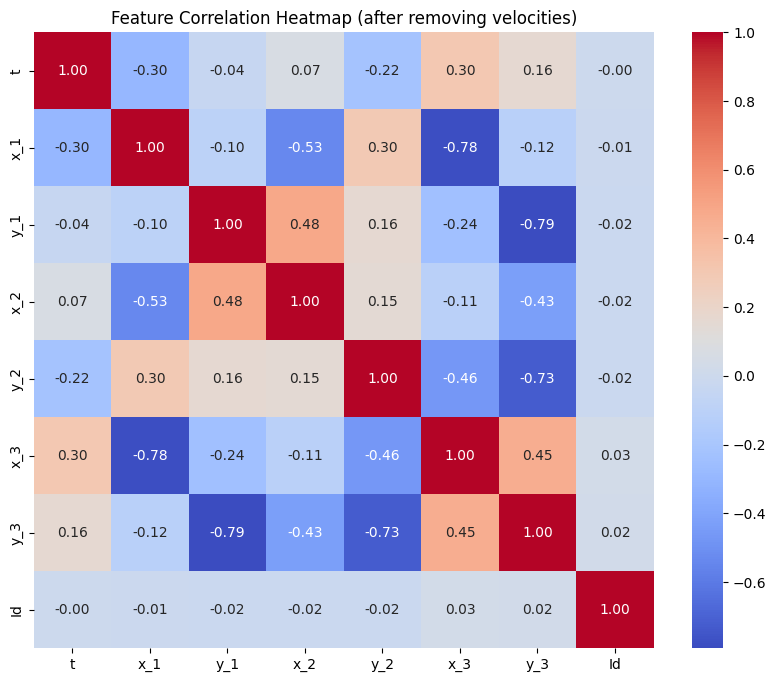

In [23]:
# drop velocity features
cols_to_drop = [f"v_x_{i}" for i in [1,2,3]] + [f"v_y_{i}" for i in [1,2,3]]
X_train_reduced = train_first_row_time.drop(columns=cols_to_drop, errors='ignore')

print(f"Removed velocity features: {cols_to_drop}")
print("Reduced shape:", X_train_reduced.shape)

# --- Step 2: visualize correlations without velocities ---
plt.figure(figsize=(10,8))
sns.heatmap(X_train_reduced.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (after removing velocities)")
plt.show()

In [27]:
print(train_first_row_time.shape)

(1090737, 14)


In [24]:
print(X_train_reduced.shape)

(1090737, 8)
